# Deep Learning Self Driving Car
#### Team members: Ingrid Hansen, Iris Loret, Dina Boshnaq
#### Group 2

## Introduction
For the deep learning model, we chose the same track as for OpenCV. We are first going to collect the data and label it according to which key was pressed. After that we will create the model and also train it. After that we will evaluate it by looking at the confusion matrix. And lastly, it's time to capture the screen and give that to our model to make predictions to what direction he should drive.

In [1]:
#Driving imports
import cv2
import pyautogui
import numpy as np
from keras.models import load_model
import keyboard
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import mss.tools
import time
import uuid
import keyboard
import pyautogui
import time
import mss.tools
import uuid
import keyboard
from pynput import mouse
#Model Imports
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.optimizers as optimizers
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten
from keras.layers import Reshape

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import resnet_v2
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from PIL import Image
import io

## Collecting data

To collect data for our model we utilized the code below. The code takes a screenshot within the boundaries specified in the code. For us this is about one third of the screen position in the centre of the y axis of the screen.

The screenshot function takes a folder as a parameter. This folder parameter is collected through key inputs while playing the game. Through this setup the images are saved in folders corresponding to the keys that are pressed while the game is being played. Through this our data is sorted with the correct label.

In [ ]:
time.sleep(5)

def screenshot(folder):
    with mss.mss() as sct:
      # Select monitor index
        monitor_info = sct.monitors[0]
        # Create a margin for the top of the screen so the area of interest is positioned correctly on the y-axis.
        top_margin = (monitor_info["height"] // 4) + 50
        # Dictionary where the portion of the monitor is determined. We add margins to correctly capture the area of interest.
        monitor = {"top": monitor_info["top"] + top_margin, "left": monitor_info["left"] + 55, "width": monitor_info["width"] - 120, "height": (monitor_info["height"] * 2 // 3)-450}
        # The output where the images are saved. The subfolder corresponds to the input, then a randomly generated file name is created.
        output = f"citydata/{folder}/{str(uuid.uuid4())}.png".format(**monitor)
        sct_img = sct.grab(monitor)
        mss.tools.to_png(sct_img.rgb, sct_img.size, output=output)
    return output

#Track keyboard input
def on_keyboard_event(event):
    print(f"{event.name}")
    return screenshot(event.name)
#Track mouse input
def on_mouse_event(x, y, button, pressed):
    print(f"{button.name}")
    return screenshot('forward')

keyboard.hook(on_keyboard_event)
with mouse.Listener(on_click=on_mouse_event) as listener:
    print("Press keys or click the mouse (Press 'Esc' to exit)")
    keyboard.wait('space')  # Wait for the 'space' key to exit the program
    listener.stop()  # Stop the mouse listener
    keyboard.unhook_all()  # Unhook the keyboard events


Display an image of every class:

Right (d): 

<img src="./tracksplit/train/d/0197a1b5-8c2b-48da-914d-897113e39e6c.png" width="700">

Left (q):

<img src="./tracksplit/train/q/043351db-3297-475b-b274-de9ae166c1cc.png" width="700">

Forward (f):

<img src="./tracksplit/train/f/002d69d1-8a13-4a47-86b4-ac3b3afea1ff.png" width="700">

Correct right (h):

<img src="./tracksplit/train/h/001b5118-5f43-4939-9287-a5fc04350919.png" width="700">

Correct left (j):

<img src="./tracksplit/train/j/2750a150-0acf-47d2-8f6d-4d164a53c7cf.png" width="700">

## Creating the Model

When deciding on a pretrained model to build our own model on we first tried out a ResNet50 model. However, with this model we could only reach about 40% accuracy with the model. After trying out various methods to increase the accuracy and conducting research we tried out some other pretrained models. Other versions of ResNet were tried and we eventually reached ResNet50V2. With this pretrained model we could reach about 93% accuracy with our model.

The data we collected is split into training and testing data. As previously stated the images are stored in folders corresponding to their labels. This dataset contains five labels:

'd': Right

'q': Left

'f': Forward

'h': Correct right

'j': Correct left

Right means that there is a turn to the right and Mario should go to the right. Left means the opposite and forward means just to go forward. Correct right is for when Mario is close to the right side of the track and should go to the left. Correct left then means that Mario is close to the left side of the track and needs to go to the right.


In [4]:
# Split the images into training and testing sets
import splitfolders
input_folder = 'trackimages'
output_folder = 'tracksplit'

# 80% training and 20% testing 
splitfolders.ratio(input_folder, output_folder, seed=40, ratio=(0.8, 0.2))

The ResNet50V2 model will be used with the imagenet weights. The top layer, which is the final fully connected layer, is excluded because our own fully connected layer is added. Our custom layer is tailored to the needs of our specific task. The input shape is set to an image size of 224x224 with three channels. This is the required image dimensions to use ResNet with imagenet.

Before setting up our own layers we set the pre-existing weights in the model to not be trainable.

In [76]:
model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [77]:
for layer in model.layers:
    layer.trainable = False

The output tensor of the model is retrieved and used as the input for the layers we add onto the model. We apply batch normalization on the inputs. Following this, a convolutional layer is added with 64 filters of the size 3x3. Max Pooling is performed followed by flattening the input. Two Dense layers are then added with 128 and 64 neurons respectively. The layers use ReLu as an activation function. The fully connected layer we add is specified to have five neurons, each corresponding to each potential output. The optimizer for the model is adam with a learning rate of 0.01. The model is compiled with the categorical crossentropy as a loss function.

In [78]:
x = model.output

x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x) 
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)

x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
classes = Dense(5, activation='softmax')(x)


model = Model(inputs=model.input, outputs=classes)
optimizer = optimizers.Adam(learning_rate=0.01)


In [79]:
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

When generating image data we perform some data augmentation. The pixel values are normalized to a 0-1 range. The images can be shifted on the width and height by 10% and can be zoomed in or out by 10%. The channel shift means that the color channels in the image could be increased or decreased by up to 20%. The brigthness can also be adjusted up to 20% up or down.

In [80]:
datagen = ImageDataGenerator(rescale=1./255,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=0.1,
                                channel_shift_range=0.2,
                                brightness_range=(0.8, 1.2))

In [81]:
# Specify the train and validation dataset
train_data = datagen.flow_from_directory("tracksplit/train", target_size=(224, 224), batch_size=120, class_mode="categorical")
val_data = datagen.flow_from_directory("tracksplit/val", target_size=(224, 224), batch_size=120, class_mode="categorical")

Found 874 images belonging to 5 classes.
Found 220 images belonging to 5 classes.


## Training the model

In [82]:
# Train the model
model.fit(train_data, epochs=5, validation_data=val_data)

Epoch 1/5
8/8 [==============================] - 169s 20s/step - loss: 8.3119 - accuracy: 0.5206 - val_loss: 3.3112 - val_accuracy: 0.7227
Epoch 2/5
8/8 [==============================] - 177s 21s/step - loss: 1.9422 - accuracy: 0.7872 - val_loss: 2.3875 - val_accuracy: 0.7409
Epoch 3/5
8/8 [==============================] - 169s 21s/step - loss: 0.9444 - accuracy: 0.8272 - val_loss: 1.1077 - val_accuracy: 0.8636
Epoch 4/5
8/8 [==============================] - 152s 19s/step - loss: 0.4816 - accuracy: 0.8913 - val_loss: 0.4668 - val_accuracy: 0.8727
Epoch 5/5
8/8 [==============================] - 172s 21s/step - loss: 0.2866 - accuracy: 0.9211 - val_loss: 0.3712 - val_accuracy: 0.8545


In [87]:
# Take an image from the validation set to test
img = image.load_img("tracksplit/val/j/0fa740d2-3491-4e1b-8159-07faacb6f634.png", target_size=(224, 224))
                     
# Convert the image to a numpy array
x = image.img_to_array(img)

# Expand the dimensions to match the shape that the model expects
x = np.expand_dims(x, axis=0)

# Preprocess the input
x = resnet_v2.preprocess_input(x)

In [88]:
# Predict a direction based on the image
direction = model.predict(x)

1/1 [==============================] - 0s 124ms/step


In [89]:
# The action index: 0=d, 1=f, 2=h, 3=j, 4=q
action_index = np.argmax(direction)
# How confident is the model in the predicted direction
confidence = direction[0][action_index]
print(action_index)
print(confidence)

3
0.99866915


In [83]:
# Take the validation directory to make predictions on
directory = 'tracksplit/val'

# Lists to store the actual and predicted classes
y_true = []
y_pred = []

# Encode the labels
le = LabelEncoder()

# Iterate over every subdirectory in the directory
for subdir in os.listdir(directory):
    subdir_path = os.path.join(directory, subdir)
    if os.path.isdir(subdir_path):
        # Iterate over every image in the subdirectory
        for filename in os.listdir(subdir_path):
            if filename.endswith(".png"):
                # Load the image
                img_path = os.path.join(subdir_path, filename)
                img = image.load_img(img_path, target_size=(224, 224))

                # Convert the image to a numpy array
                x = image.img_to_array(img)

                # Expand the dimensions to match the shape that the model expects
                x = np.expand_dims(x, axis=0)

                # Preprocess the input
                x = resnet_v2.preprocess_input(x)

                # Make a prediction
                predictions = model.predict(x)

                # Get the index of the class with the highest probability
                predicted_class = np.argmax(predictions)

                # Add the actual and predicted classes to the lists
                # The actual class is the name of the subdirectory
                y_true.append(subdir)
                y_pred.append(predicted_class)

                continue
            else:
                continue
# Transform the labels to numerical labels
y_true = le.fit_transform(y_true)
# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print(cm)

1/1 [==============================] - 0s 167ms/step
[[48  8  0  0  0]
 [ 2 55  0  0  3]
 [ 0  0 17  4  0]
 [ 6  2  0 26  0]
 [ 0  3  0  0 46]]


In [90]:
# Display the encoded labels with the original labels
for i, class_name in enumerate(le.classes_):
    print(f"Encoded label {i} corresponds to original label '{class_name}'")

Encoded label 0 corresponds to original label 'd'
Encoded label 1 corresponds to original label 'f'
Encoded label 2 corresponds to original label 'h'
Encoded label 3 corresponds to original label 'j'
Encoded label 4 corresponds to original label 'q'


In [84]:
# Save the model
model.save('trackv3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


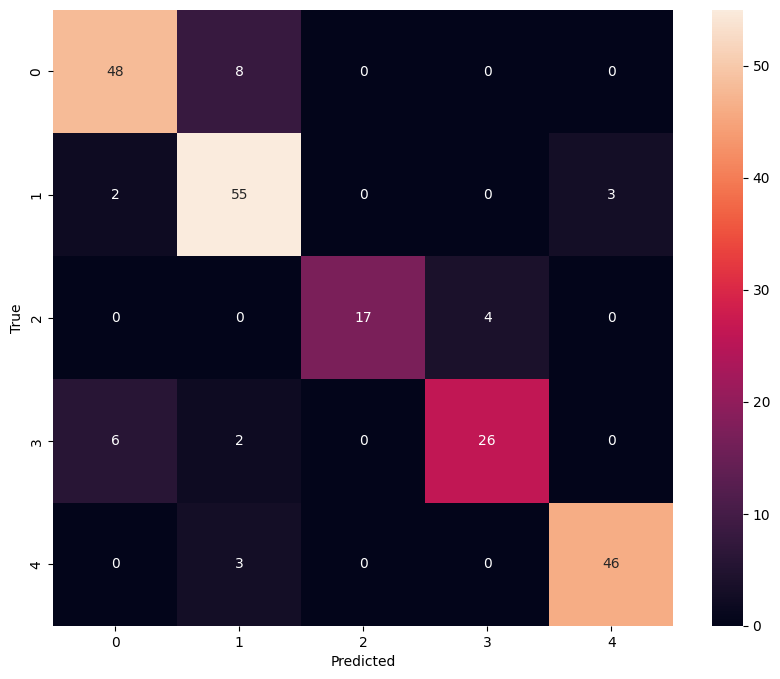

In [85]:
# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

From this confusion matrix we can see that our model mostly performs well on all classes. There are a few labels wrongly predicted. The maximum amount of wrongly predicted labels for one class is 8 and the minimum is 3. 

The most mistakes are made in predicting 'right' and 'correct left'. 'Right' was predicted as 'forward' sometimes, and for 'correct left' the model confused it for 'right' the most. Which makes sense and isn't that big of a problem since 'right' and 'correct left' should both go right. 

The class that performs the best is 'left' and then 'correct right'. The model confuses 'left' the most for 'forward' and 'correct right' for 'correct left', which is a problem but luckily it was only wrong in 4 cases.

The class 'forward' predicted 5 times the wrong class. It sees it sometimes as 'left' or 'right'.

In [ ]:
# Load the model that will be used to control Mario
model = load_model('trackv3.h5')

## Let's run Mario!

In [ ]:
# Let the model predict based on an image, which direction to go
def determine_direction(img):
    # Resize the image
    img = img.resize((224, 224))
    # Convert the image to a numpy array
    x = image.img_to_array(img)
    # Expand the dimensions to match the shape that the model expects
    x = np.expand_dims(x, axis=0)
    # Preprocess the input
    x = resnet_v2.preprocess_input(x)
    # Let the model predict the direction
    x = model.predict(x)
    # Set a threshold
    threshold = 0.60
    # Get the predicted value
    action_index = np.argmax(x)
    print(action_index)
    # Retrieve the confidence score for the predicted value
    confidence = x[0][action_index]
    print(confidence)
    # When the threshold is bigger than the confidence, return 6 so the else statement will be triggered later on
    # Else, return the predicted class
    if threshold > confidence:
        print('back')
        return 6
    return action_index
    

In [ ]:
# Define the codec using VideoWriter_fourcc() and create a VideoWriter object
# Sleep so we are able to open the game
time.sleep(5)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (1920,1080))
sct = mss.mss()
monitor_info = sct.monitors[0]

# Define dimensions of the screen we want to capture
top_margin = (monitor_info["height"] // 4) + 50
monitor = {
    "top": monitor_info["top"] + top_margin,
    "left": monitor_info["left"] + 55,
    "width": monitor_info["width"] - 120,
    "height": (monitor_info["height"] * 2 // 3) - 450}

# Stop when space is pressed
while not keyboard.is_pressed("space"):
    # Capture computer screen
    screenshot = sct.grab(monitor)
    img = np.array(screenshot)
    # Create an image from the screenshot and save it in memory
    img = Image.frombytes('RGB', screenshot.size, screenshot.rgb)
    bytes_io = io.BytesIO()
    img.save(bytes_io, format='PNG') 
    # Predict the direction
    direction = determine_direction(img)
    #0=d, 1=f, 2=h, 3=j, 4=q
    if (direction == 0):
        # Go right
        print('right')
        pyautogui.mouseDown()
        keyboard.press('d')
        time.sleep(0.35)
        keyboard.release('d')
        pyautogui.mouseUp()
    elif (direction == 4):
        # Go left
        print('left')
        pyautogui.mouseDown()
        keyboard.press('q')
        time.sleep(0.3)
        keyboard.release('q')
        pyautogui.mouseUp()
    elif (direction == 1):
        # Go forward
        print('forward')
        pyautogui.mouseDown()  
        time.sleep(0.5)           
        pyautogui.mouseUp()
    elif (direction == 2): 
        # Correct the right - go left
        print('c-right')
        pyautogui.mouseDown()
        keyboard.press('q')
        time.sleep(0.3)
        keyboard.release('q')
        pyautogui.mouseUp()
    elif (direction == 3): 
        # Correct the left - go right
        print('c-left')
        pyautogui.mouseDown()
        keyboard.press('d')
        time.sleep(0.3)
        keyboard.release('d')
        pyautogui.mouseUp()
    else: 
        # Go backwardds
        pyautogui.mouseDown(button='right')
        time.sleep(0.4)
        pyautogui.mouseUp(button='right')
    time.sleep(0.1)

# Release everything when job is finished
out.release()
cv2.destroyAllWindows()

## Problems we encountered

1. Preprocessing the images

After multiple attempts where we were trying to get Mario to drive but he wasn’t, we started thinking the problem might be our data. We collected data several times and made sure to clean it well. But even then the issue remained. To check whether the problem was with our dataset or not, we fed our data to Google Teachable Machine and the model we got was surprisingly good. So that confirmed that the issue was not, in fact, from our data. We decided to check the model again as the problem seemed to lie there. But we couldn’t find any issue, so we consulted the teacher about it. Apparently the issue was with how we were preprocessing the images. The way we were doing it when training the model was different from when starting the game and taking screenshots while driving. To check on how the predictions were being made, we made a confusion matrix. 
After carefully looking at the code once more, specifically at the preprocessing part, we found that we weren't using this when making predictions: resnet_v2.preprocess_input(x). This processes the image into the format that the ResNet model needs. When we fixed that Mario actually started driving, so problem fixed. Here’s a comparison in the confusion matrixes before and after...

- Old Confusion Matrix:

<img src="oldConfusionMatrix.jpg" width="700"/>

- New Confusion Matrix:

<img src="newConfusionMatrix.jpg" width="700"/>

We learn from this that image preprocessing is a vital step when making the model. And the way you do it during training should match the way it’s done when capturing images during testing.

2. Getting the correct data we needed (data suited for the track)

Cleaning the data (images) wasn’t the easiest. Not all the images taken matched the label they were assigned to (the folder they were stored in). So we had to make sure that this data was properly cleaned so that it would match the correct move to take on this specific track.

3. Dealing with sharp turns

Another problem we encountered was that Mario might not know how hard he needs to turn to the left or right. Some turns are wide and large and some are smaller. We thought of adding 2 additional classes which were meant to take a turn when the road was diagonal. This could also help if Mario was in a poor angle after a turn, helping him get back on track instead of going forward outside of the track. After testing this, changing the speed didn't really help but in general implementing these two classes did make the model perform slightly better. The problem with this might be that there wasn't enough data of the large turns.

## Conclusion

In conclusion, we can say that Mario can drive some parts of this specific course on his own, but in some parts of the track he still has a hard time figuring out which direction he should go. Our model definitely wasn't the best for driving altough the accuracy and confusion matrix looked really good. We tried to train a Google Teachable Machine model for our data and while the confusion matrix for that model also looked good, it wasn't able to drive perfectly. Maybe this means that Mario Kart is too hard to control for a deep learning model. We even tried it with a different track, but this was even a bit worse then the current track we are using which is the same as the OpenCV part.

Throughout this assignment we learned how to use ResNet50v2 to train a model and to use preprocessing on the image. 

What we would have done differently is probably that we would have chosen a different game since Mario is a bit too hard, since the model performs well but when it actually needs to drive it doesn't perform that great, even with the Teachable Machine model. Maybe we need even more data and when we had a bit more time we could have tried that.

We are proud of the way Mario can sometimes follow the track and that he sometimes knows what direction he needs to go to.

##### Alternate Approach

A different approach we wanted to attempt was to change the way we were handling and labelling our data. The concept would be to instead of having folders with labels we would have labels in the file names. These file names would contain which button(s) were pressed and the duration of how long they were pressed. This could potentially help Mario scale both large and small turns while keeping him on track. This still leaves the risk of Mario going off track depending on his angle after a turn. Another issue is the duration of how forward(left mouse click) would be handled, as generally in the game it would be pressed for long durations if not through the entire course. However it is unsure how effective this approach would be without first implementing it. Unfortunately we ran out of time before we could implement this approach.